In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch

## 确定数据集

shape of moons: (10000, 2)


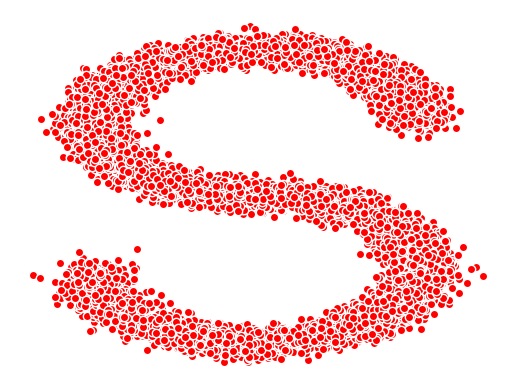

In [4]:
s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0

print("shape of moons:",np.shape(s_curve))

data = s_curve.T
#print(data)

fig,ax = plt.subplots()
ax.scatter(*data,color = 'red',edgecolor = 'white');
ax.axis('off')

dataset = torch.Tensor(s_curve).float()


## 确定超参数

In [6]:
num_steps = 100 #对于步骤 一开始可以由bata、分布的均值和标准差来共同确定

#制定每一步的beta
betas = torch.linspace(-6,6,num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

#计算alpha、alpha_prod、alpha_prod_previous、alpha_bar_sart等变量的值
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas,0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]],0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1-alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1-alphas_prod)

assert alphas.shape == alphas_prod.shape == alphas_prod_p.shape== \
alphas_bar_sqrt.shape == one_minus_alphas_bar_log.shape == \
one_minus_alphas_bar_sqrt.shape
print("all the same shape:", betas.shape)


all the same shape: torch.Size([100])


## 确定扩散过程任意时刻的采样值

In [7]:
#计算任意时刻的x的采样值，基于x_0和参数重整化技巧
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    
    noise = torch.randn_like(x_0) #nosie是从正态分布中随机生成的随机噪声
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t*x_0 + alphas_1_m_t*noise) #在x[0]的基础上添加噪声

In [36]:
#print(dataset)
#q_x(dataset,0)

tensor([[-0.0486,  0.0059],
        [-0.0889, -0.1546],
        [-0.0146, -0.2040],
        ...,
        [-0.0825,  0.0250],
        [ 0.0844,  0.1606],
        [ 0.0889, -0.0659]])


tensor([[-0.0465,  0.0025],
        [-0.0878, -0.1550],
        [-0.0148, -0.2011],
        ...,
        [-0.0790,  0.0300],
        [ 0.0924,  0.1635],
        [ 0.0861, -0.0668]])

## 演示原始数据分布加噪100步的效果

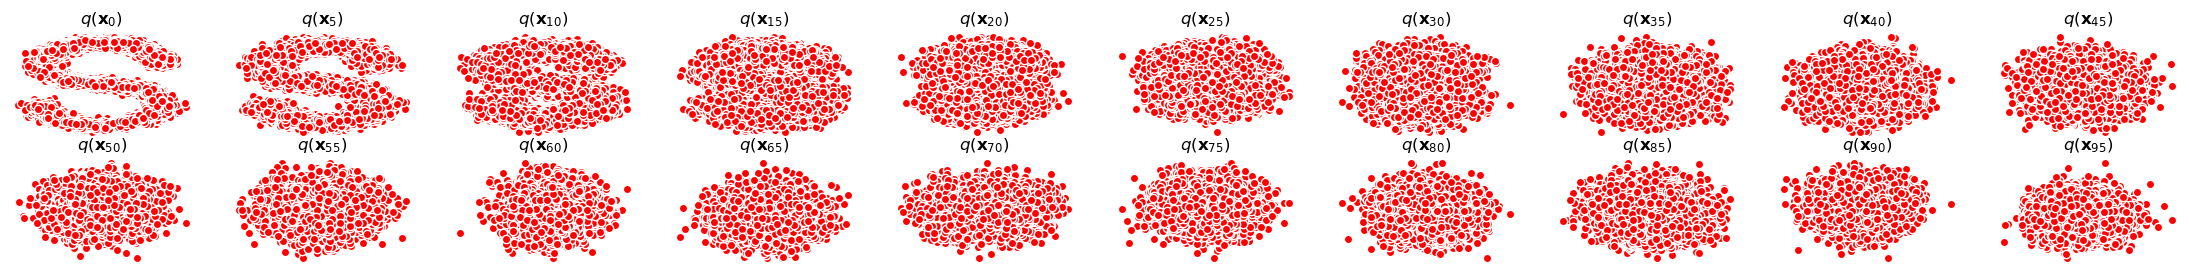

In [8]:
num_shows = 20
fig, axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='blue')

#共有10000个点，每个点包含两个坐标
#生成100步以内每隔5步加噪声后的图像
for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) #生成t时刻的采样数据
    #print(q_i)
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color = 'red',edgecolor = 'white')
    
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')

## 编写拟合逆扩散过程高斯分布的模型

In [9]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    def __init__(self,n_steps,num_units=128):
        super(MLPDiffusion,self).__init__()
        
        self.linears = nn.ModuleList(
        
            [
                nn.Linear(2,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,num_units),
                nn.ReLU(),
                nn.Linear(num_units,2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
        
            [
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
                nn.Embedding(n_steps,num_units),
            ]
        )
    def forward(self,x_0,t):
        x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)
        x = self.linears[-1](x)
        
        return x

## 编写训练的误差函数

In [24]:
def diffusion_loss_fn(model,x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    """对任意时刻的t进行采样计算loss"""
    batch_size = x_0.shape[0]
    
    #对一个batchsize样本生成随机的时刻t，覆盖到更多不同的t
    
    t = torch.randint(0,n_steps,size = (batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)
    
    #x0的系数
    a = alphas_bar_sqrt[t]
    
    #eps的系数
    aml = one_minus_alphas_bar_sqrt[t]
    
    #生成随机噪声eps
    e = torch.randn_like(x_0)
    
    #构造模型的输入
    x = x_0 * a + e * aml
    
    #送入模型，得到t时刻的随机噪声预测值
    output = model(x,t.squeeze(-1))
    
    #与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

## 编写逆扩散采样函数(inference过程)

In [25]:
def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]、...、x[0]"""
    
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    
    t = torch.tensor([t])
    
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    
    eps_theta = model(x,t)
    
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))
    
    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    
    sample = mean + sigma_t * z
    
    return (sample)

## 开始训练模型，并打印loss及中间的重构效果

Trainning model...
tensor(0.4915, grad_fn=<MeanBackward0>)
tensor(0.5905, grad_fn=<MeanBackward0>)
tensor(0.1785, grad_fn=<MeanBackward0>)
tensor(0.2710, grad_fn=<MeanBackward0>)
tensor(0.3221, grad_fn=<MeanBackward0>)
tensor(0.2308, grad_fn=<MeanBackward0>)
tensor(0.3426, grad_fn=<MeanBackward0>)
tensor(0.5654, grad_fn=<MeanBackward0>)
tensor(0.4445, grad_fn=<MeanBackward0>)
tensor(0.5064, grad_fn=<MeanBackward0>)
tensor(0.3359, grad_fn=<MeanBackward0>)
tensor(0.2347, grad_fn=<MeanBackward0>)
tensor(0.2492, grad_fn=<MeanBackward0>)
tensor(0.2031, grad_fn=<MeanBackward0>)
tensor(0.3352, grad_fn=<MeanBackward0>)
tensor(0.4594, grad_fn=<MeanBackward0>)
tensor(0.1917, grad_fn=<MeanBackward0>)
tensor(0.5992, grad_fn=<MeanBackward0>)
tensor(0.4903, grad_fn=<MeanBackward0>)
tensor(0.8122, grad_fn=<MeanBackward0>)
tensor(0.3183, grad_fn=<MeanBackward0>)


C:\Users\Administrator.DESKTOP-3TR2DTA\AppData\Local\Temp\ipykernel_2092\629971491.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,10,figsize=(28,3))


tensor(0.2629, grad_fn=<MeanBackward0>)
tensor(0.2685, grad_fn=<MeanBackward0>)
tensor(0.2284, grad_fn=<MeanBackward0>)
tensor(0.2363, grad_fn=<MeanBackward0>)
tensor(0.2480, grad_fn=<MeanBackward0>)
tensor(0.1443, grad_fn=<MeanBackward0>)
tensor(0.5803, grad_fn=<MeanBackward0>)
tensor(0.3009, grad_fn=<MeanBackward0>)
tensor(0.1600, grad_fn=<MeanBackward0>)
tensor(0.3238, grad_fn=<MeanBackward0>)
tensor(0.2299, grad_fn=<MeanBackward0>)
tensor(0.5277, grad_fn=<MeanBackward0>)
tensor(0.5736, grad_fn=<MeanBackward0>)
tensor(0.2627, grad_fn=<MeanBackward0>)
tensor(0.1578, grad_fn=<MeanBackward0>)
tensor(0.5920, grad_fn=<MeanBackward0>)
tensor(0.4801, grad_fn=<MeanBackward0>)
tensor(0.3601, grad_fn=<MeanBackward0>)
tensor(0.4009, grad_fn=<MeanBackward0>)


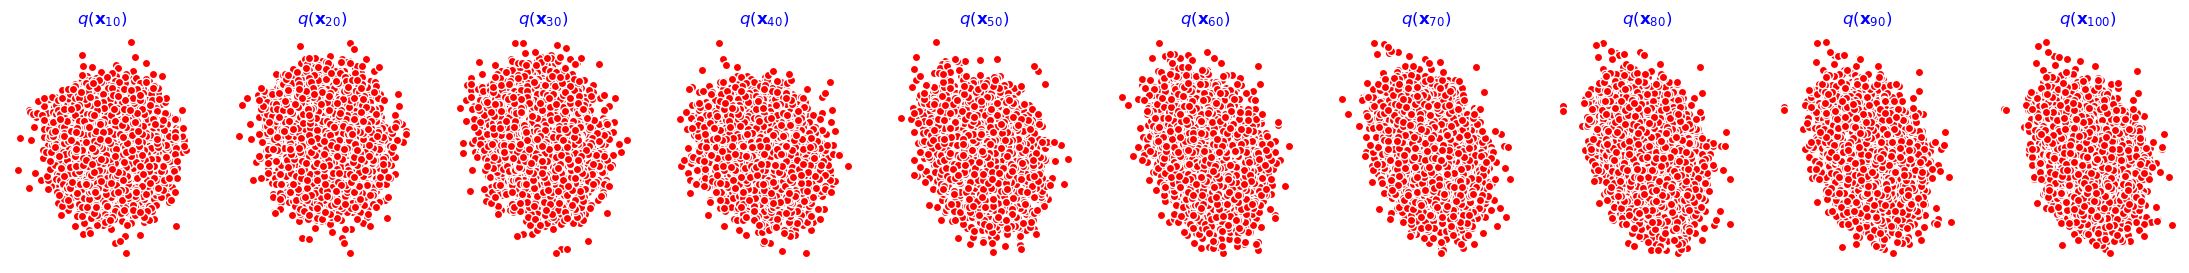

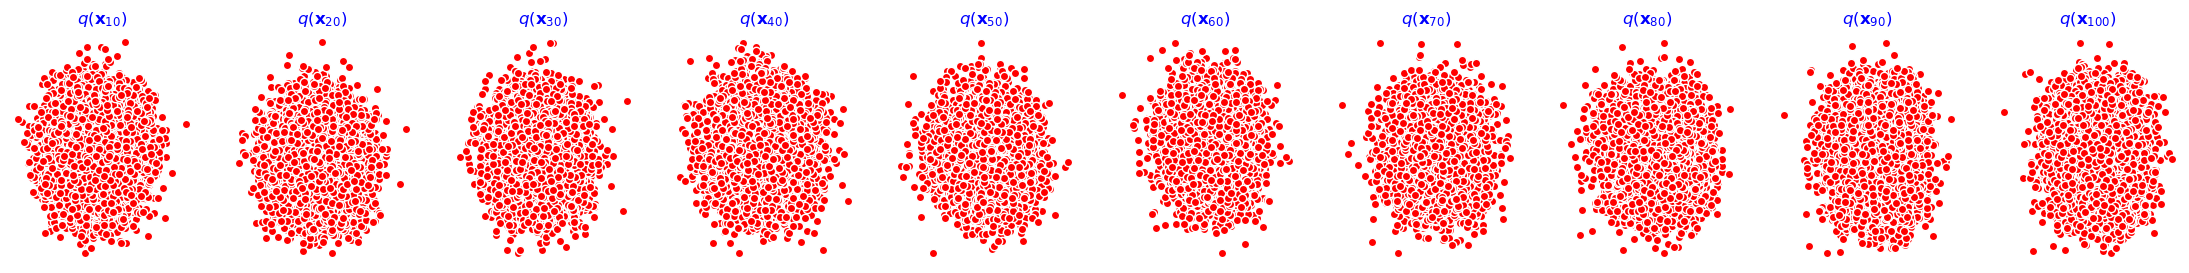

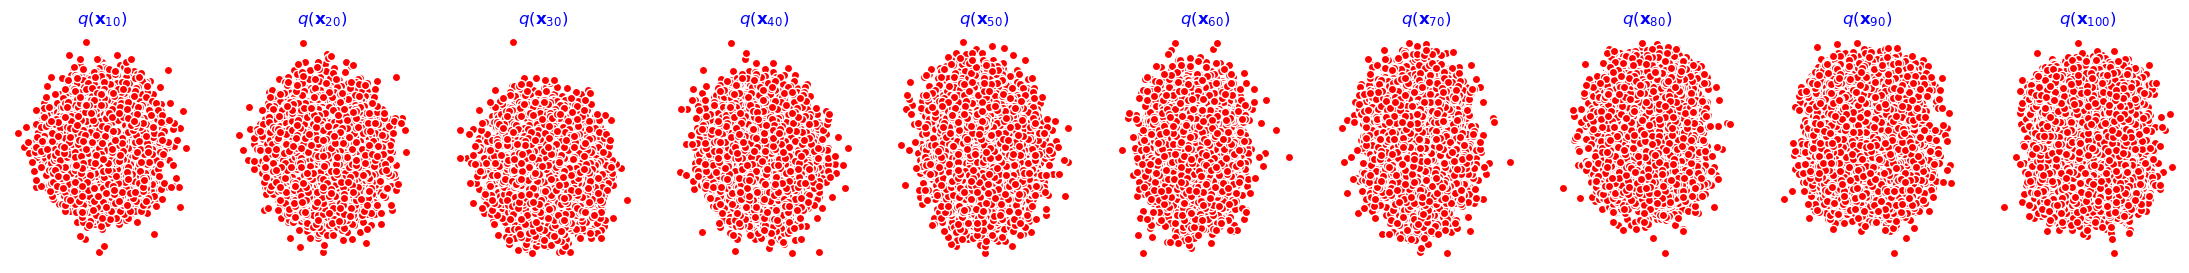

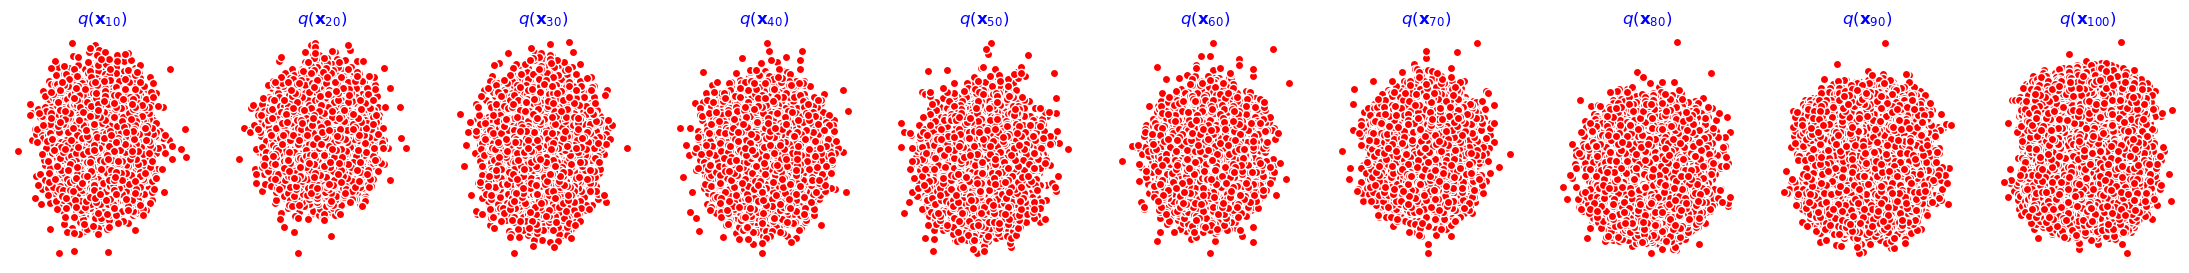

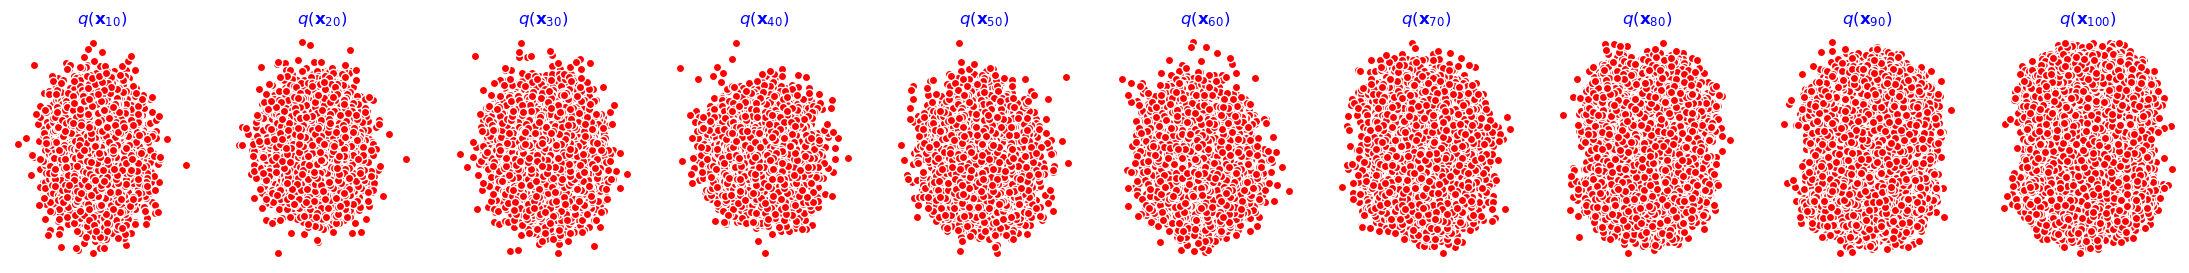

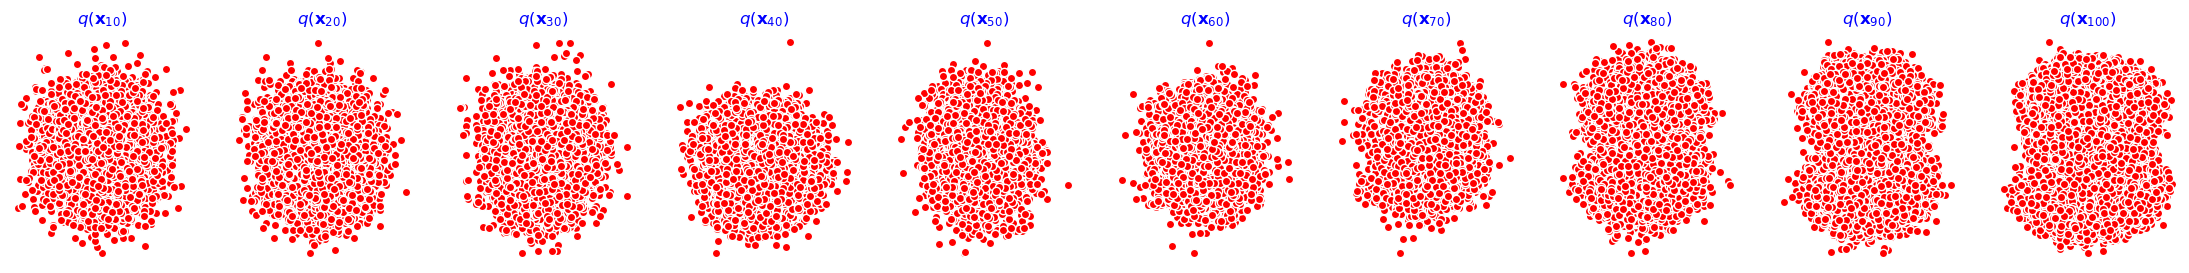

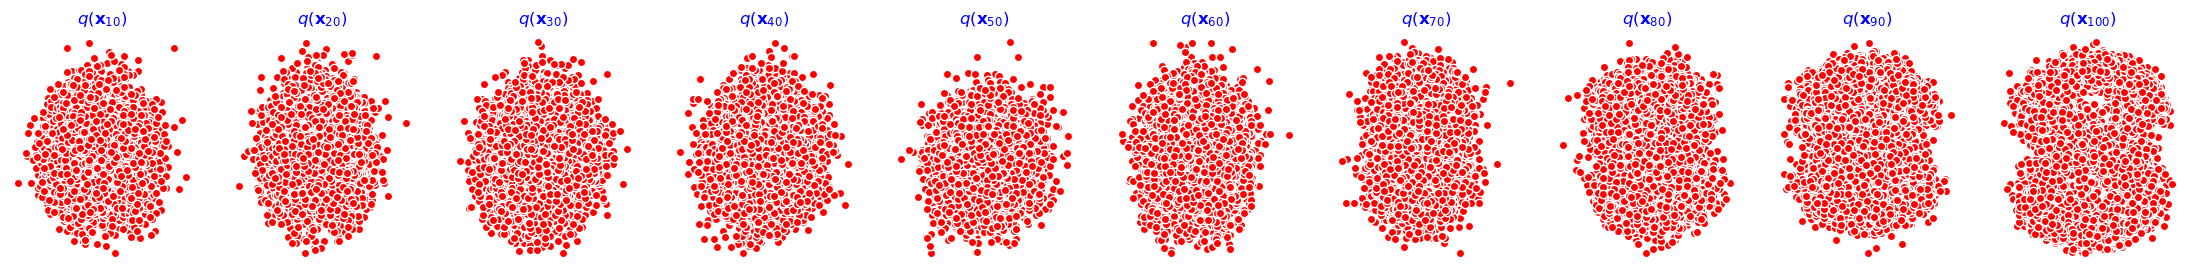

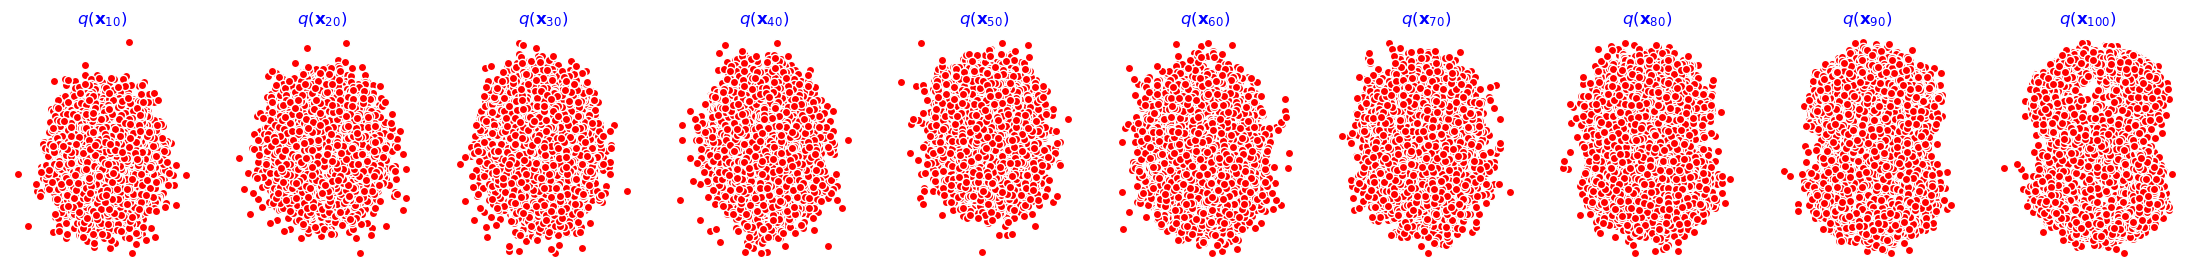

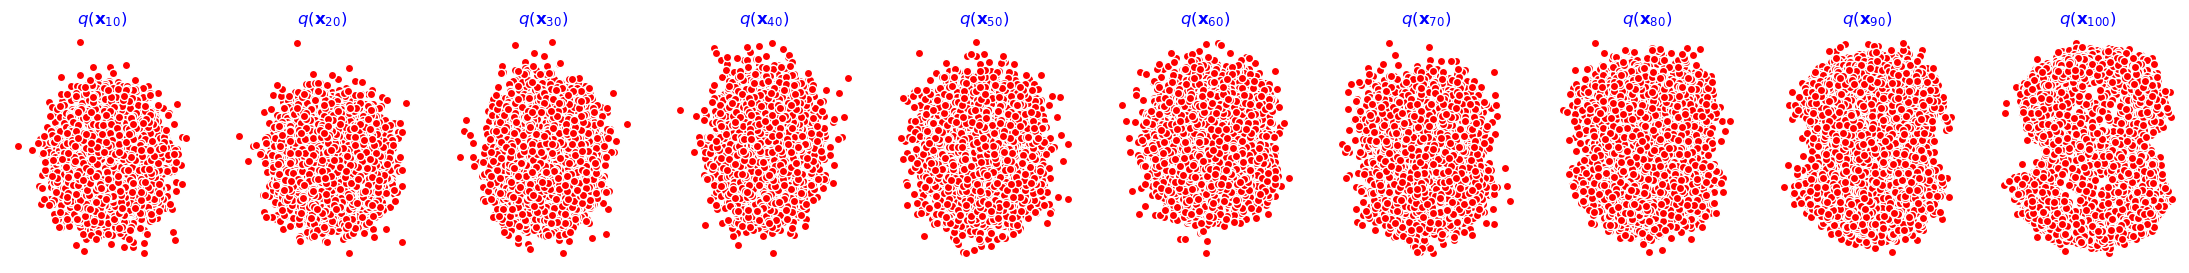

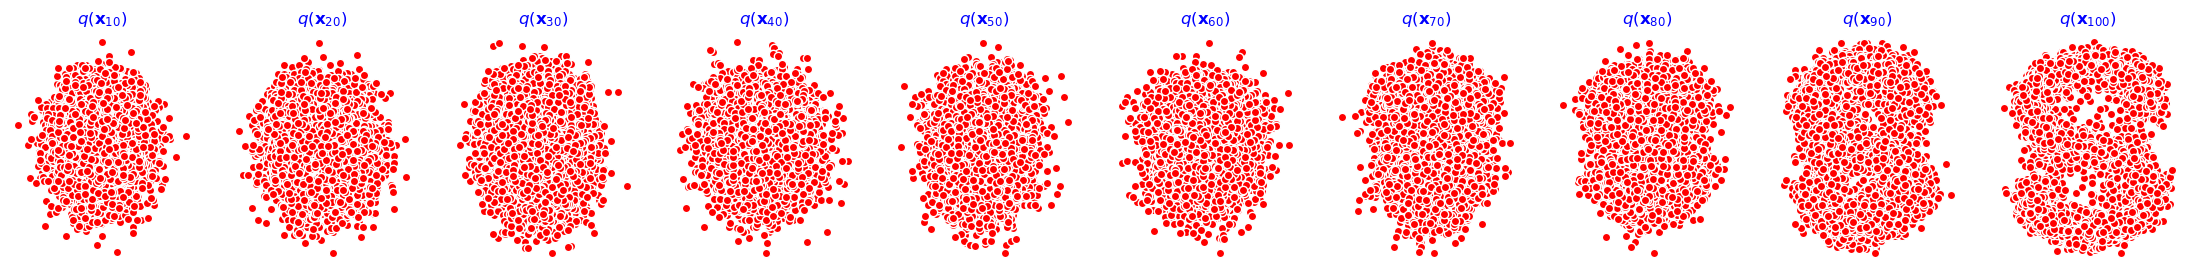

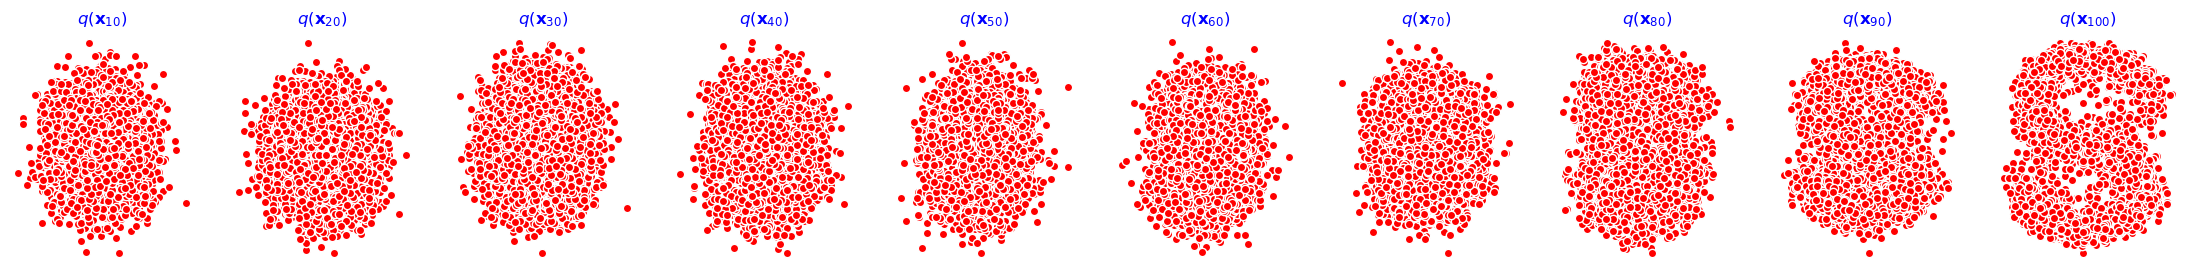

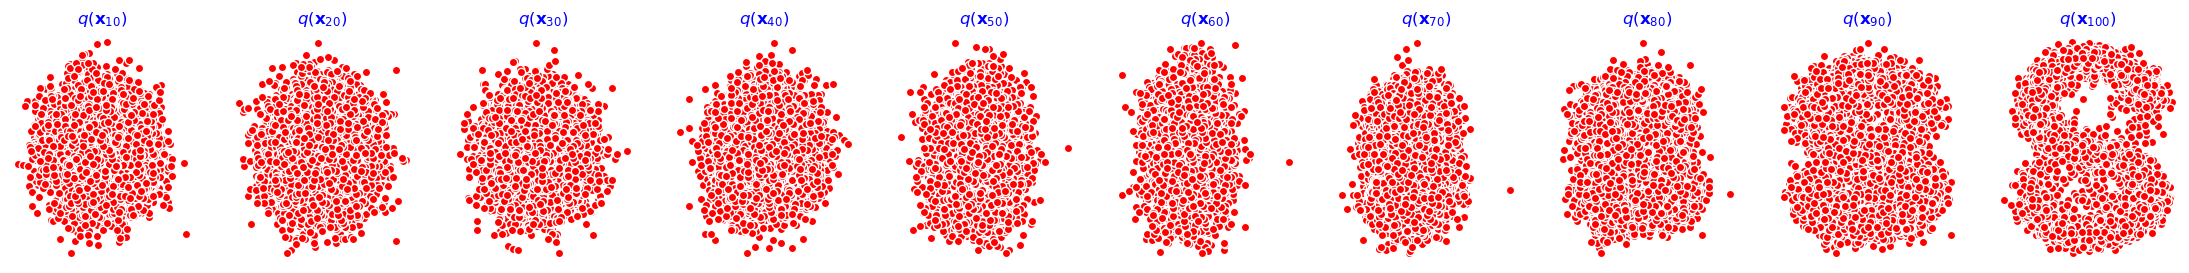

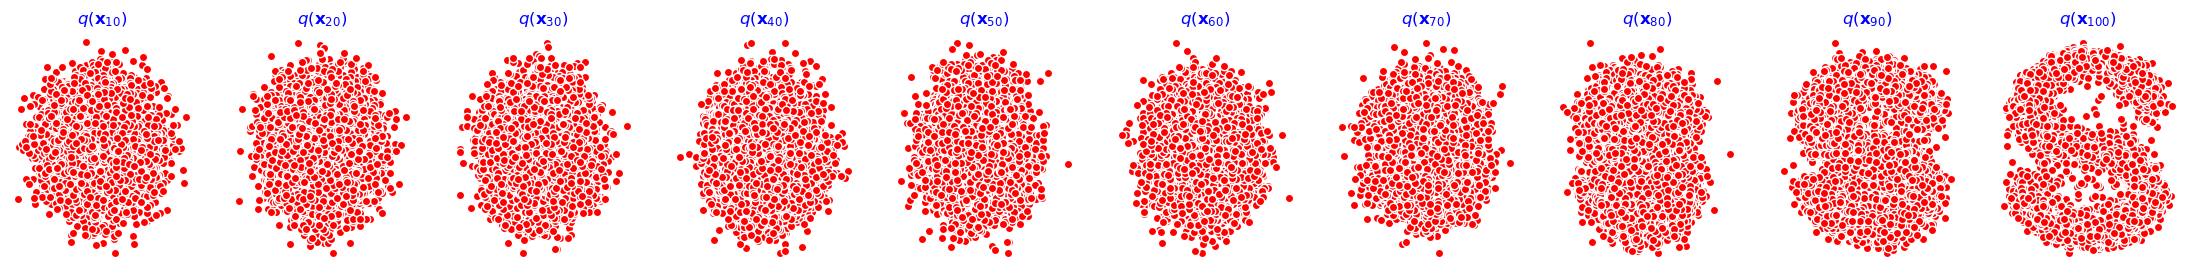

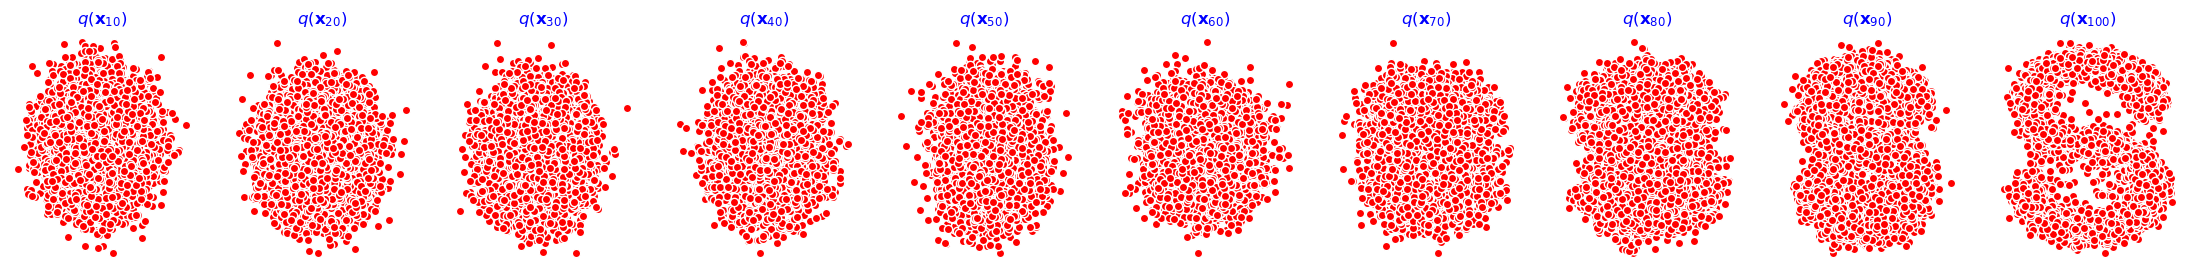

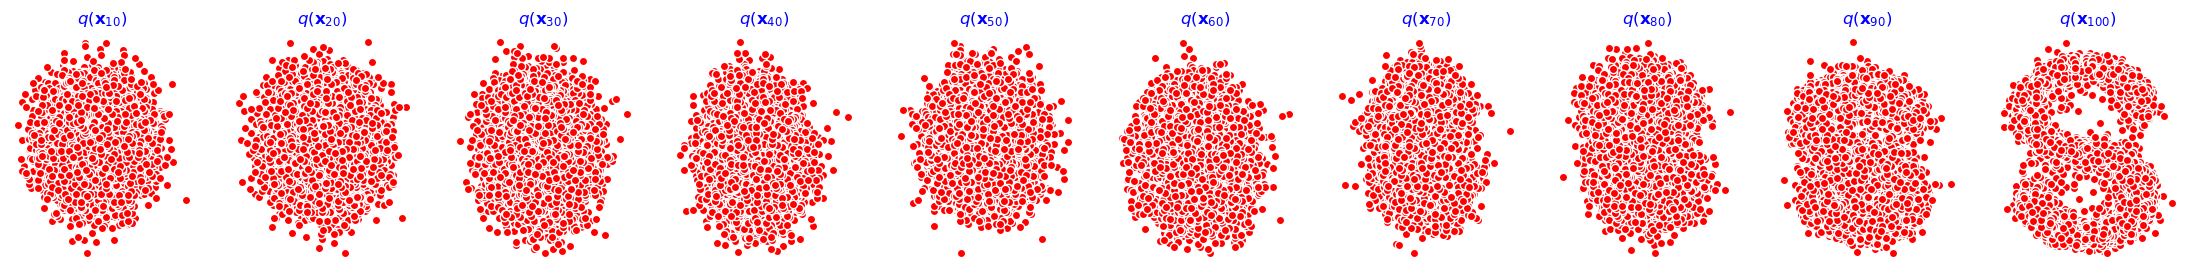

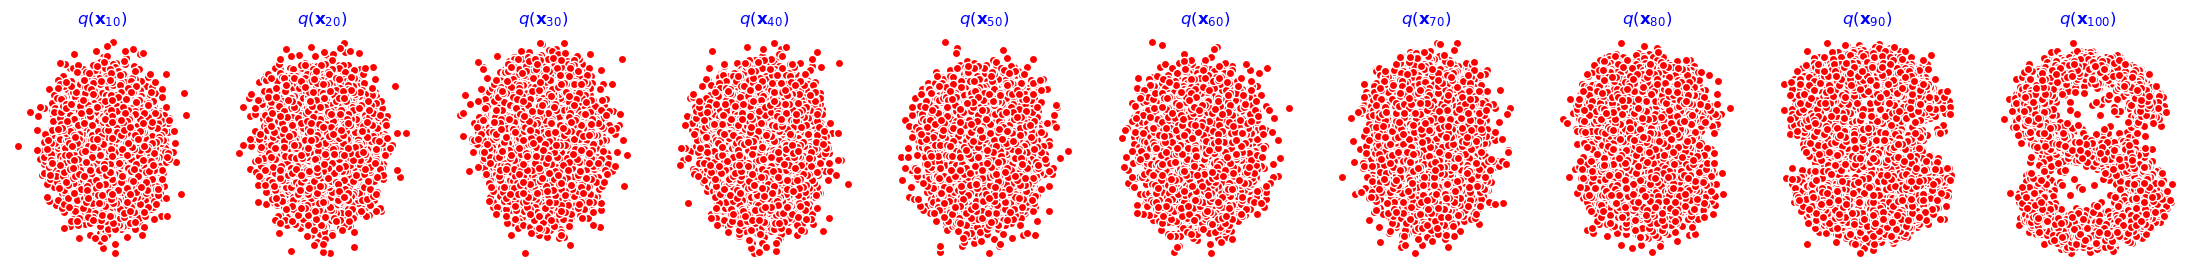

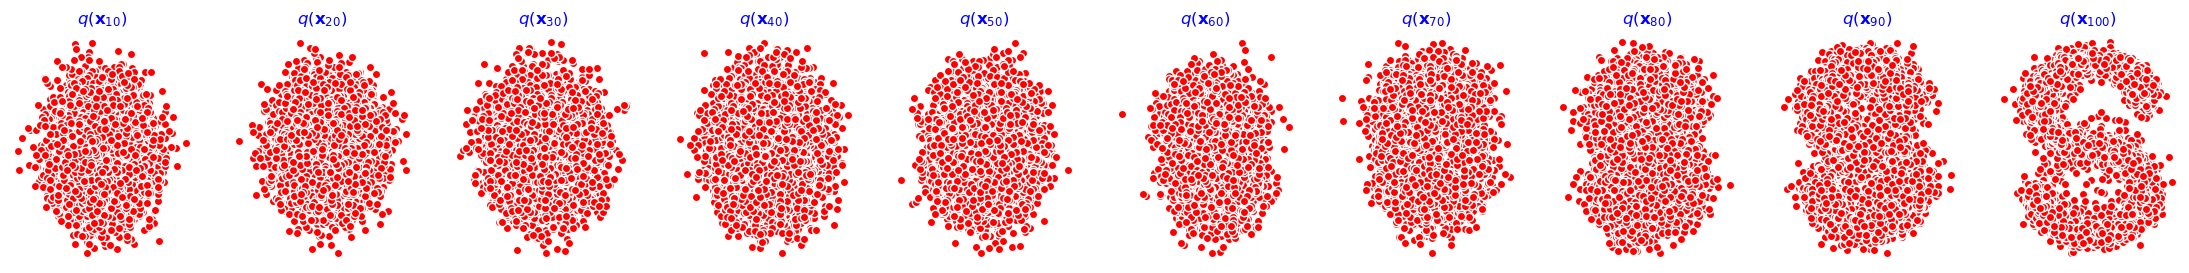

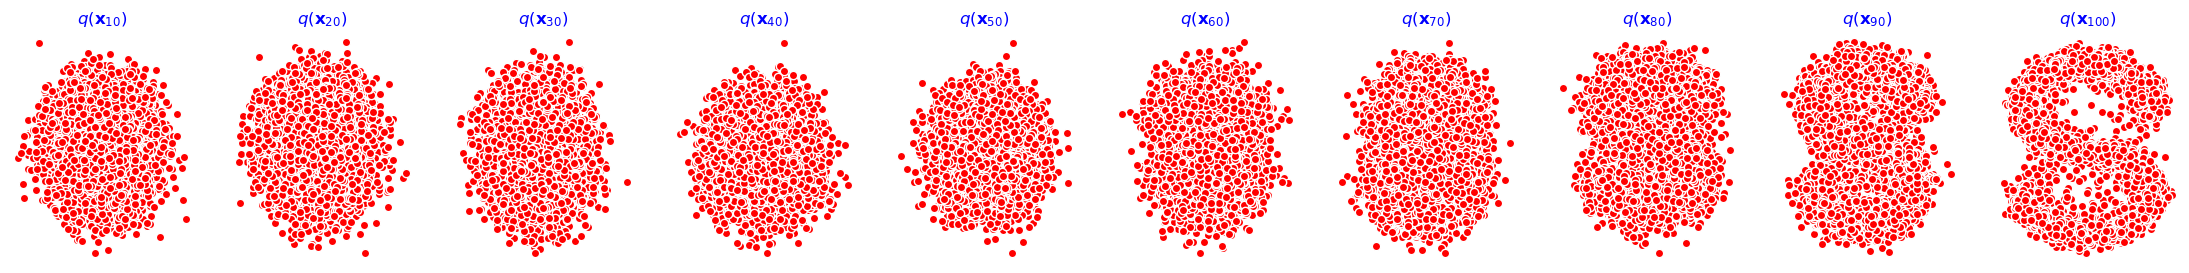

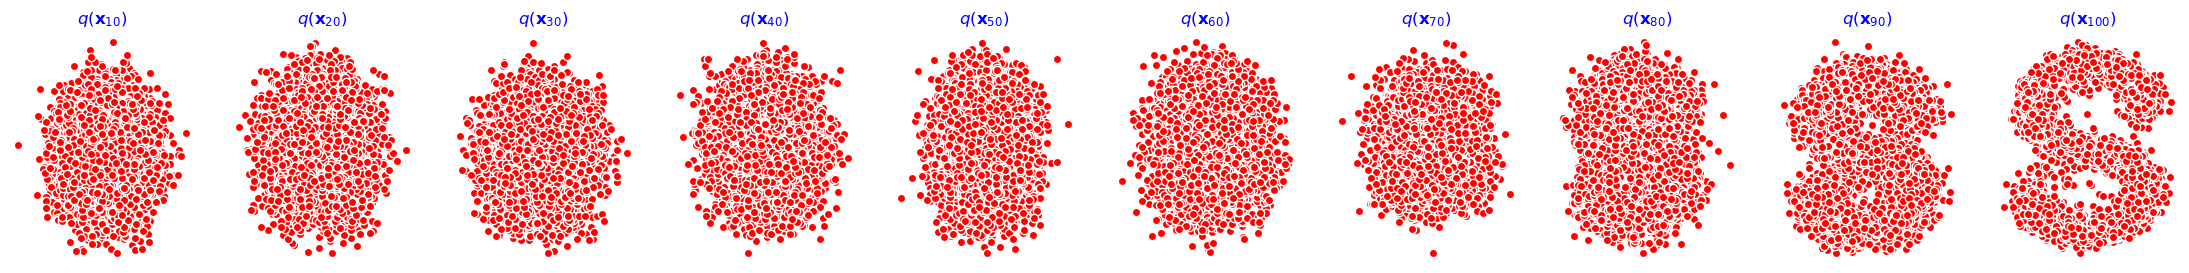

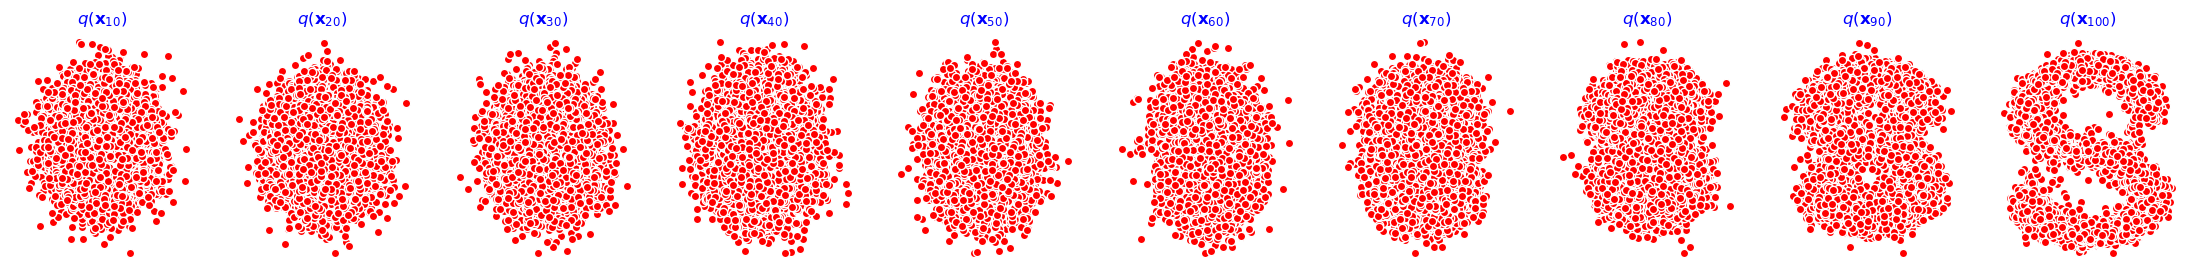

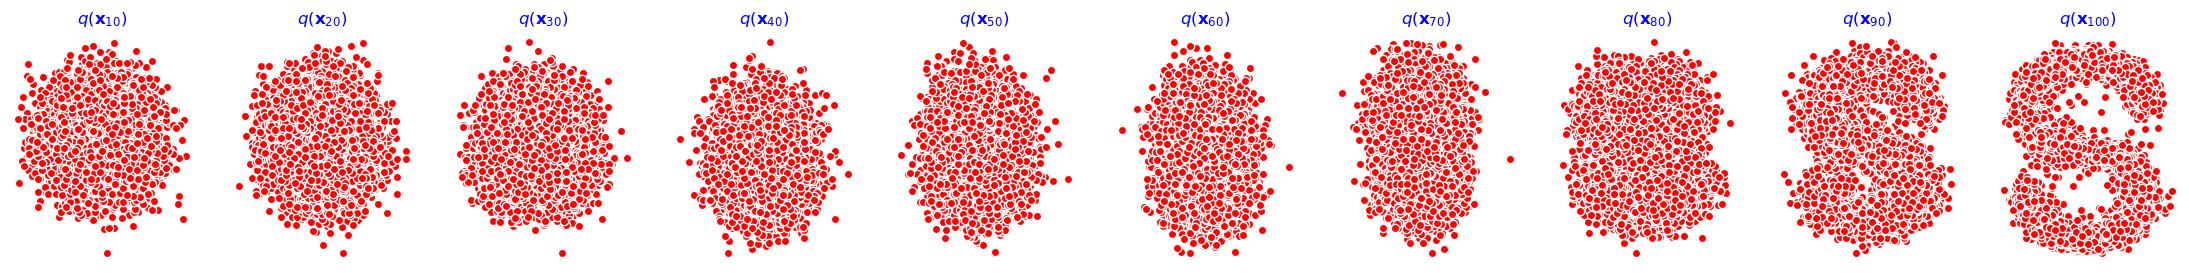

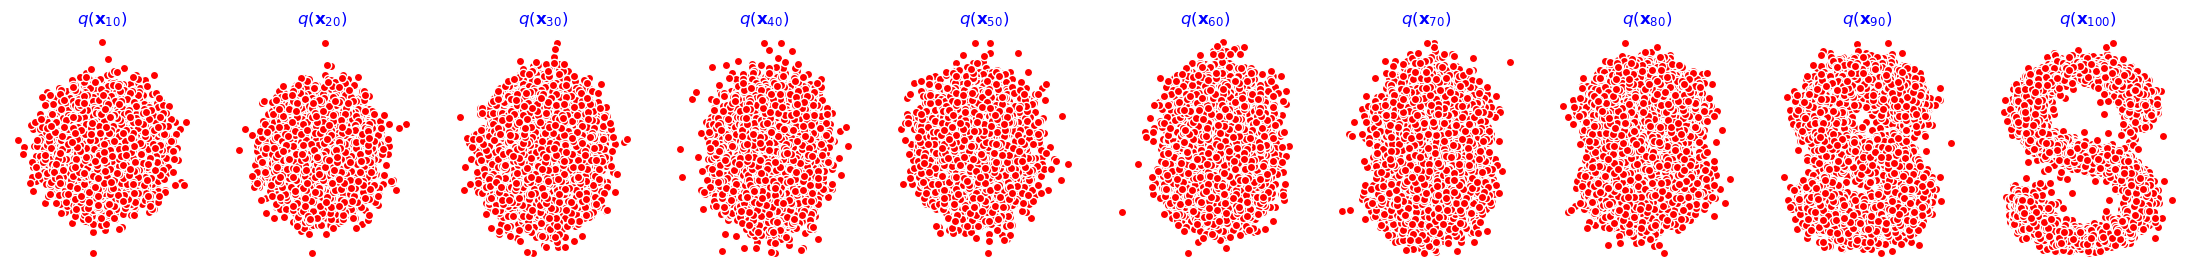

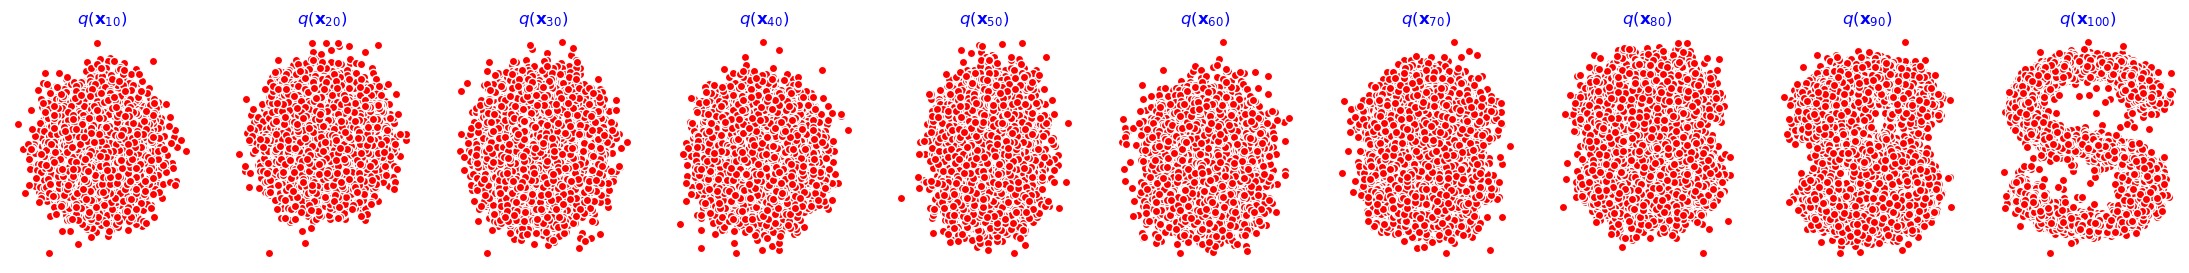

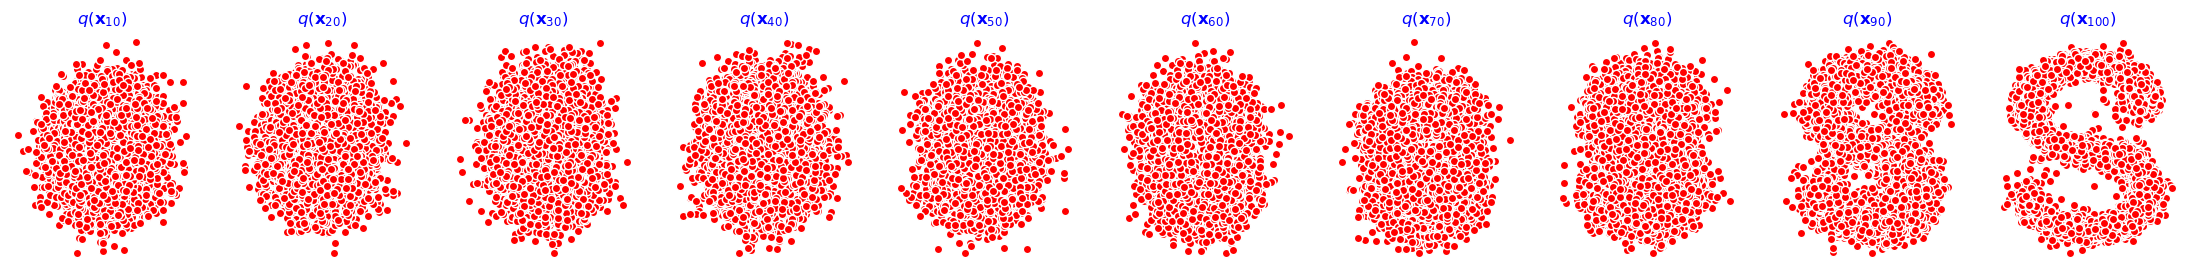

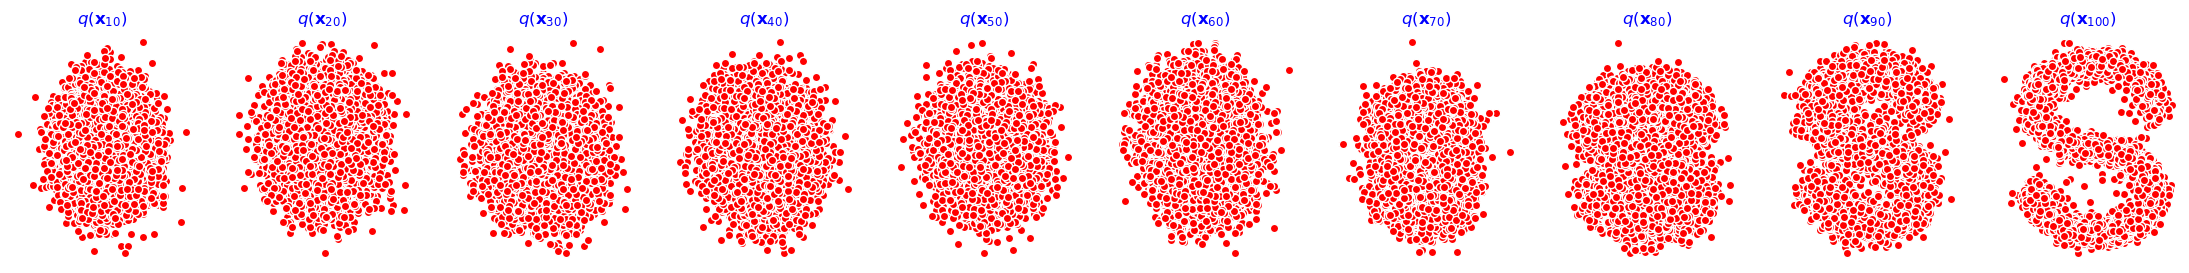

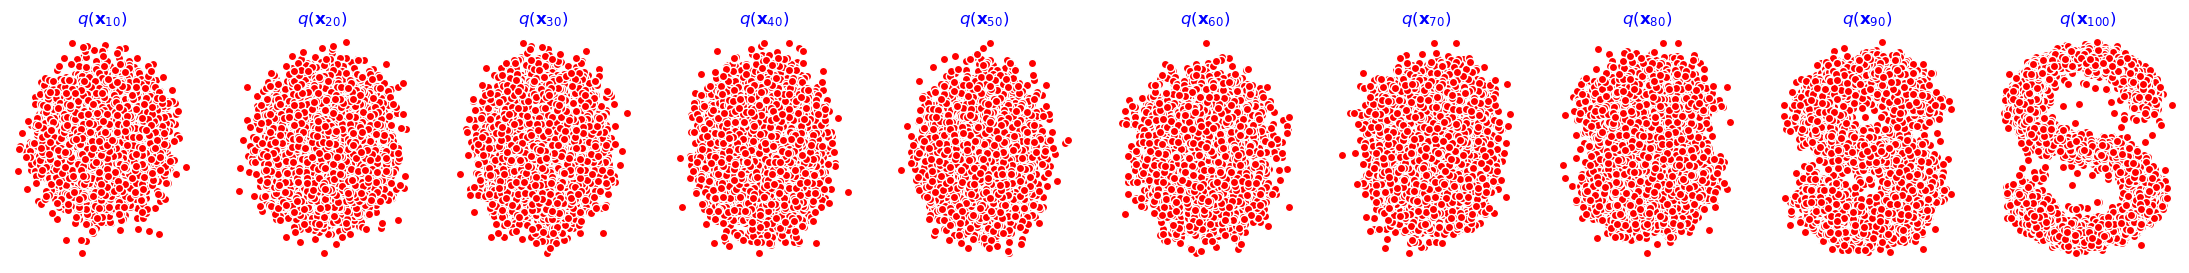

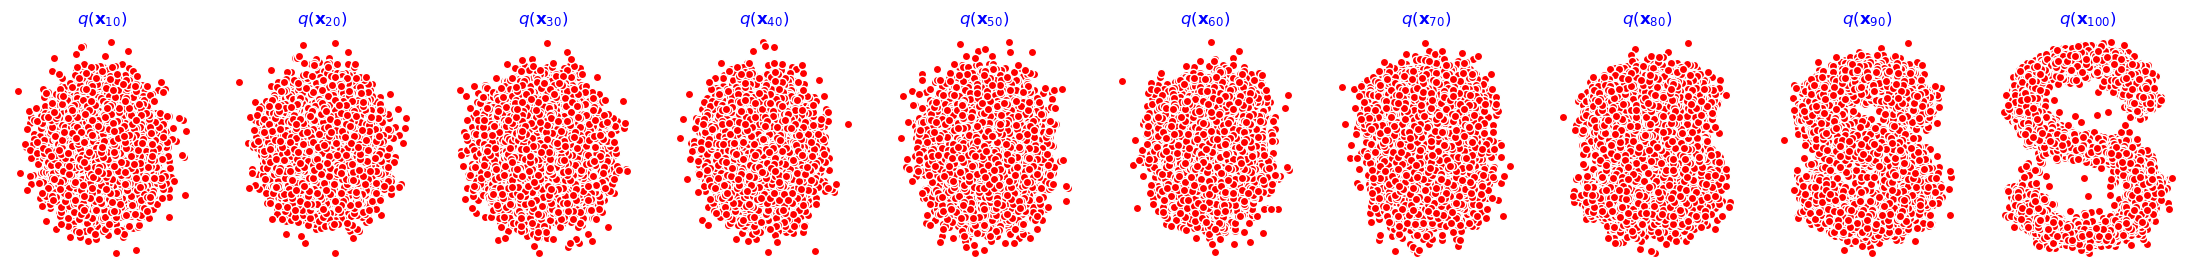

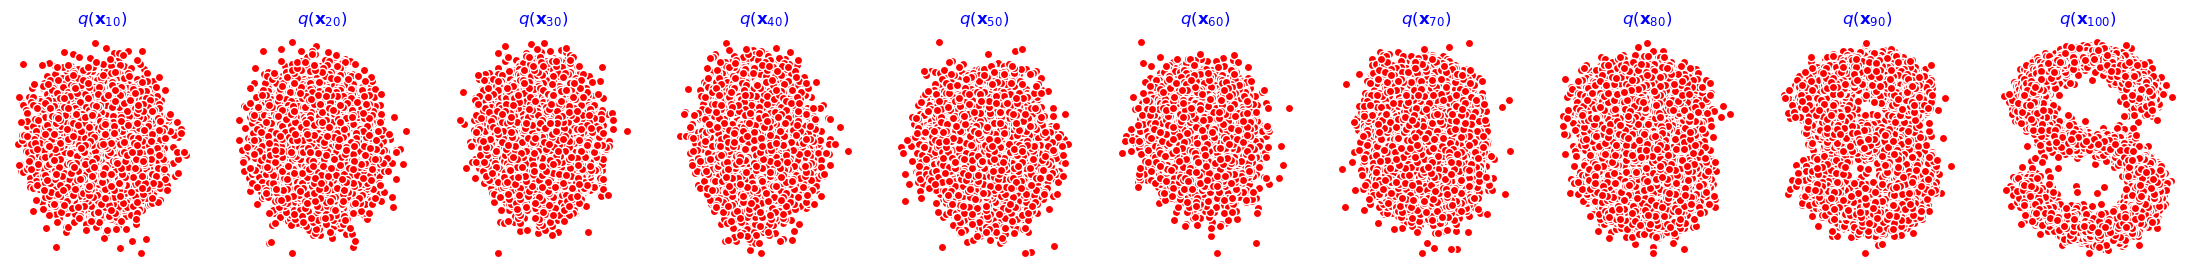

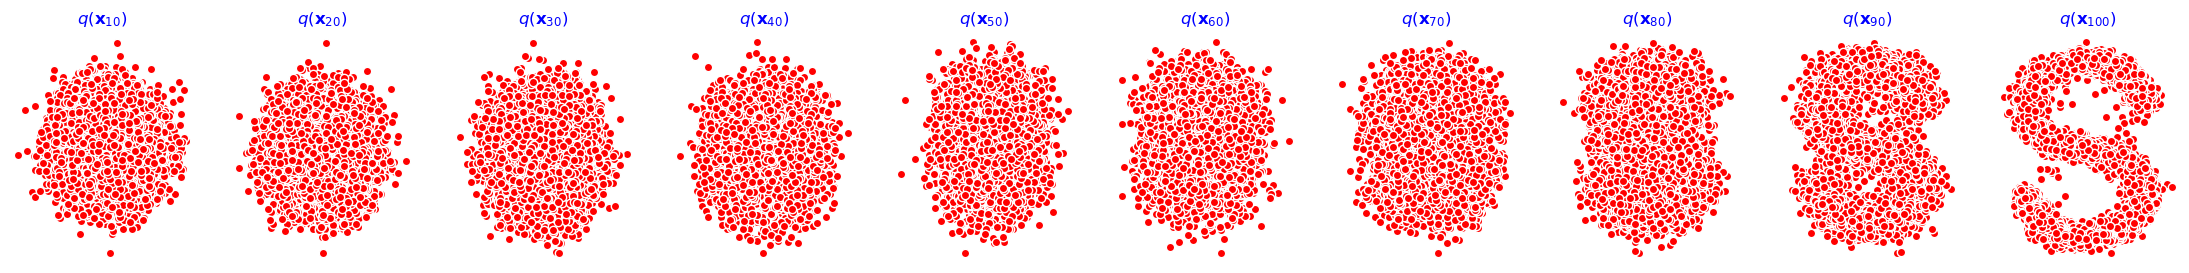

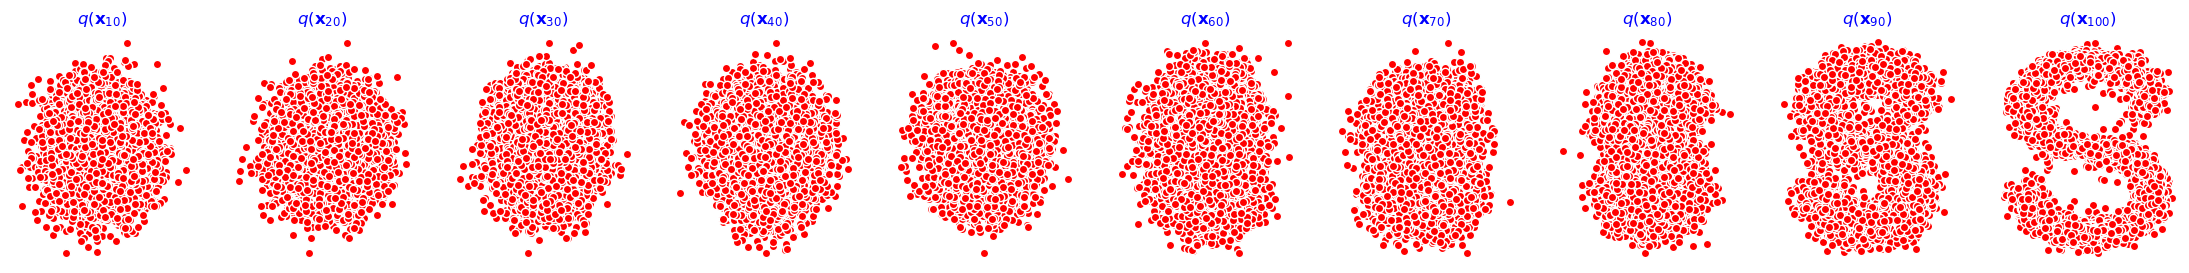

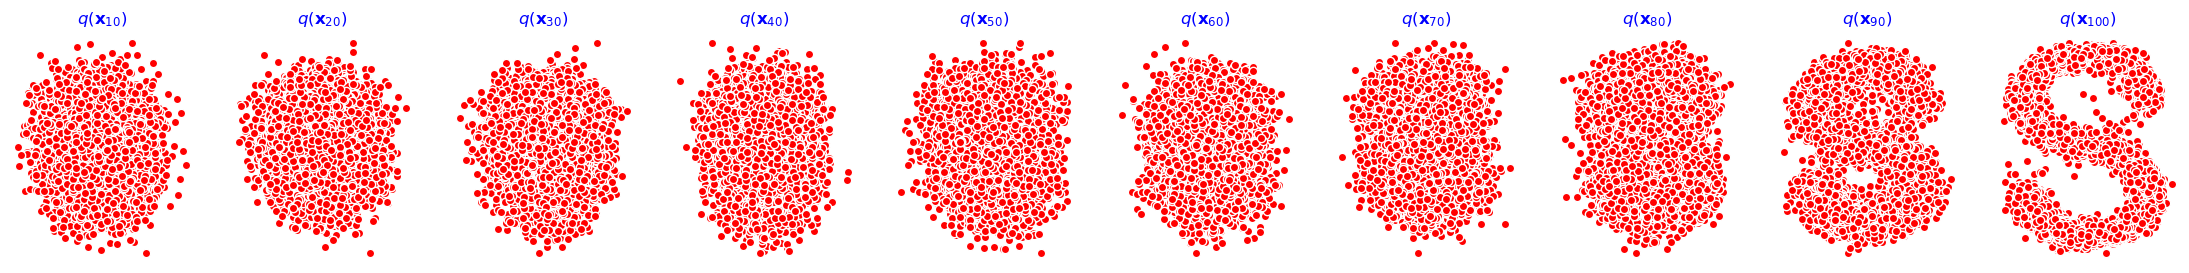

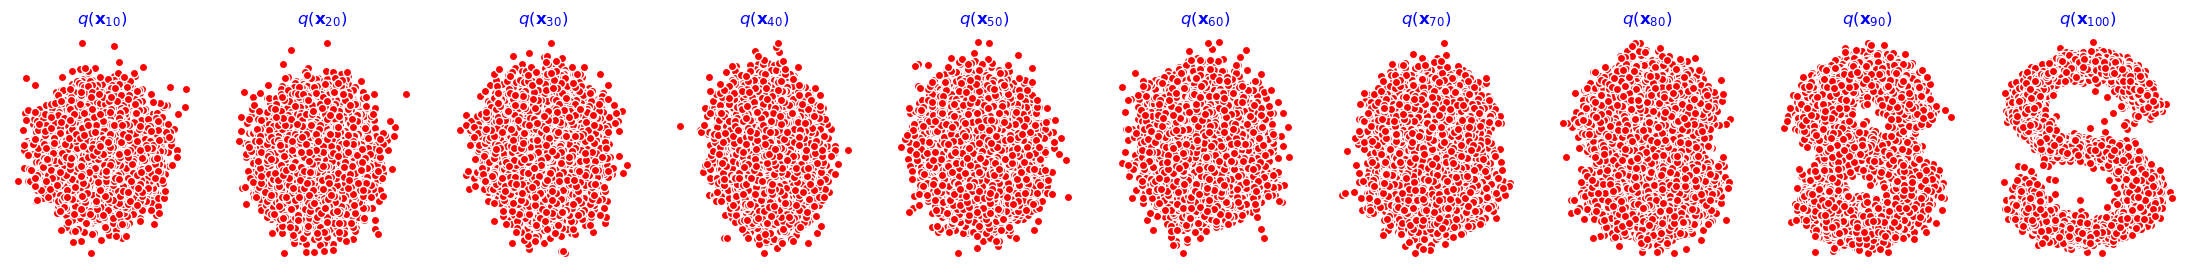

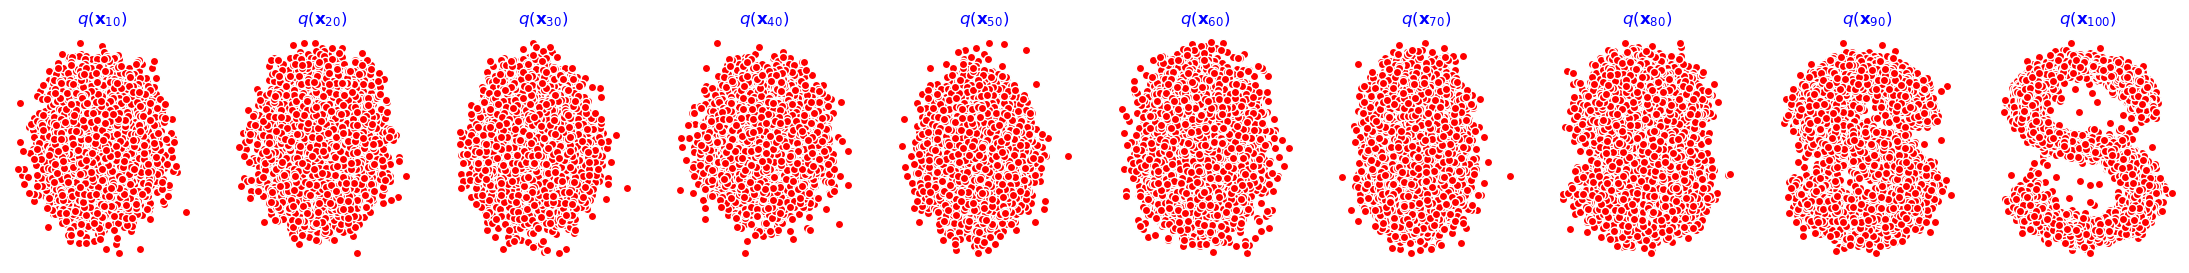

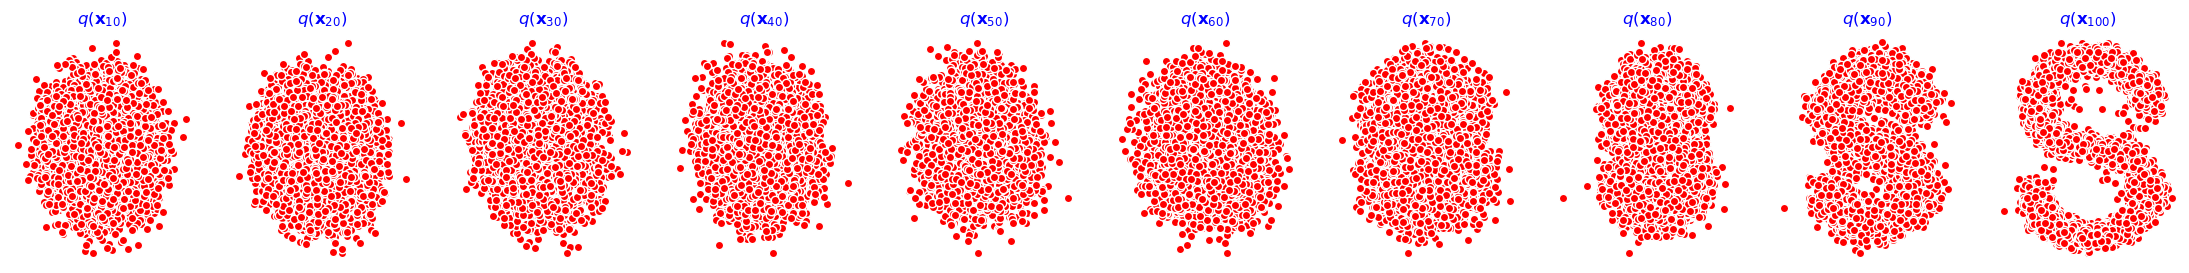

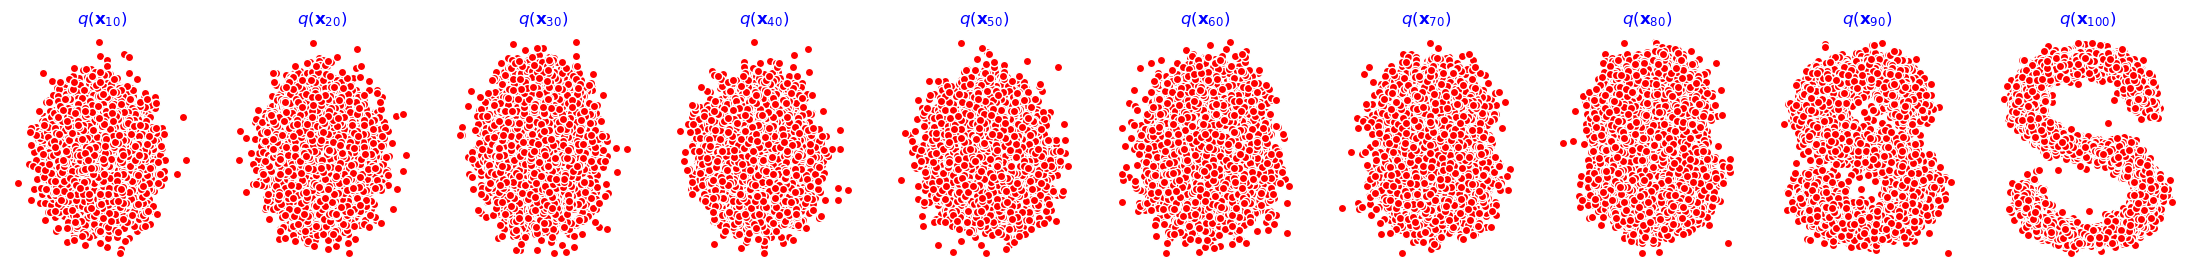

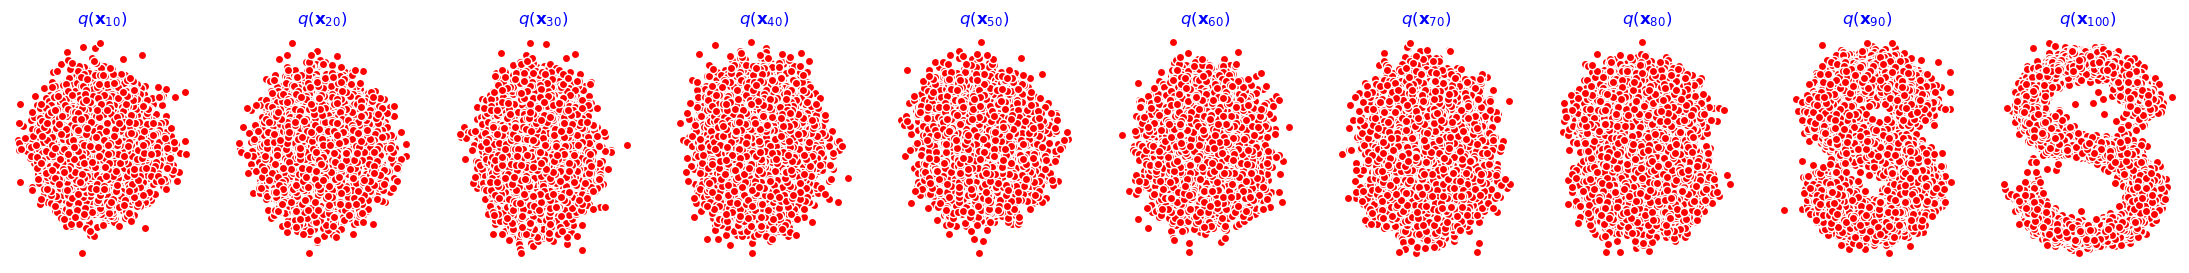

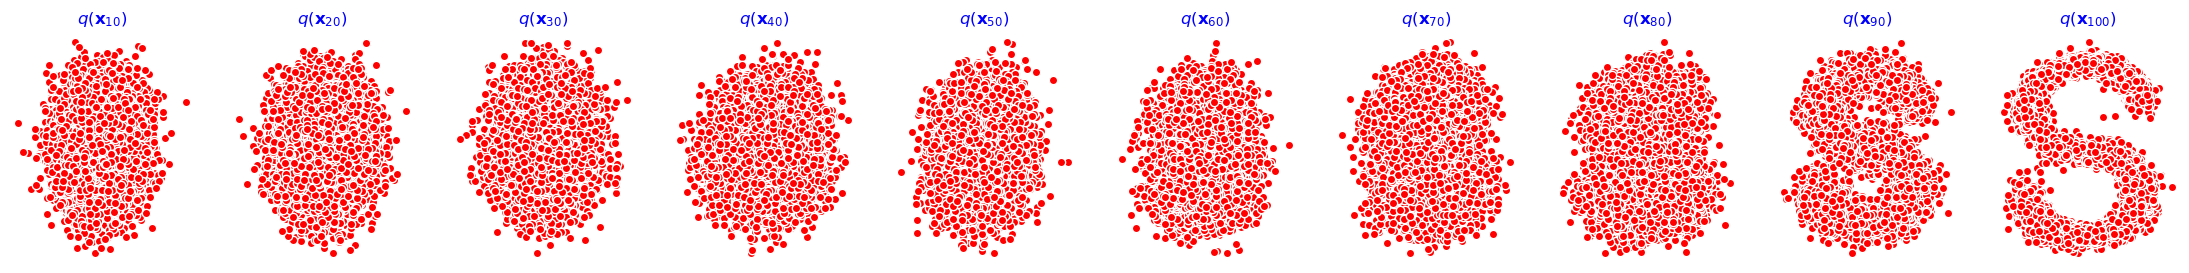

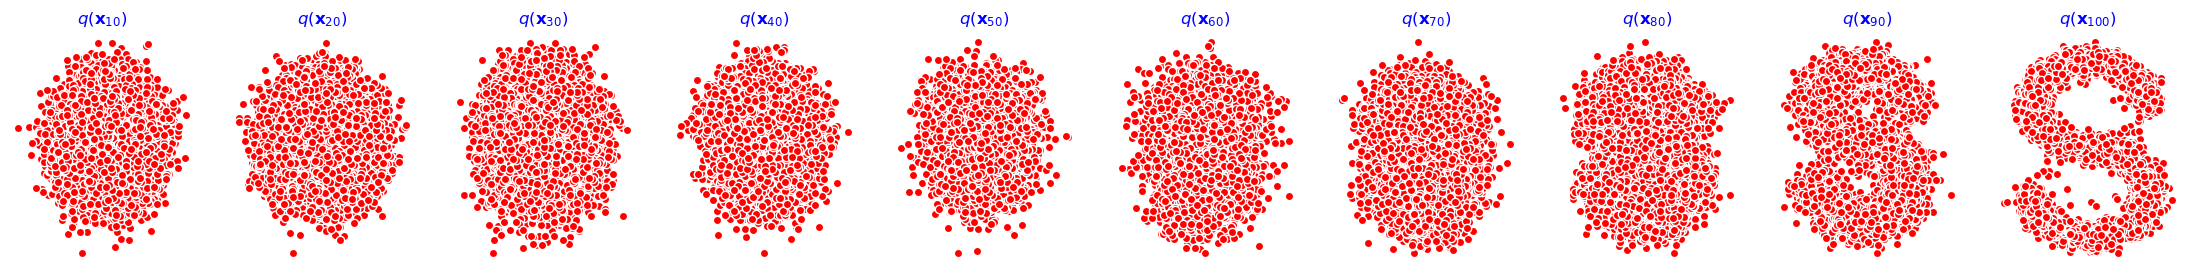

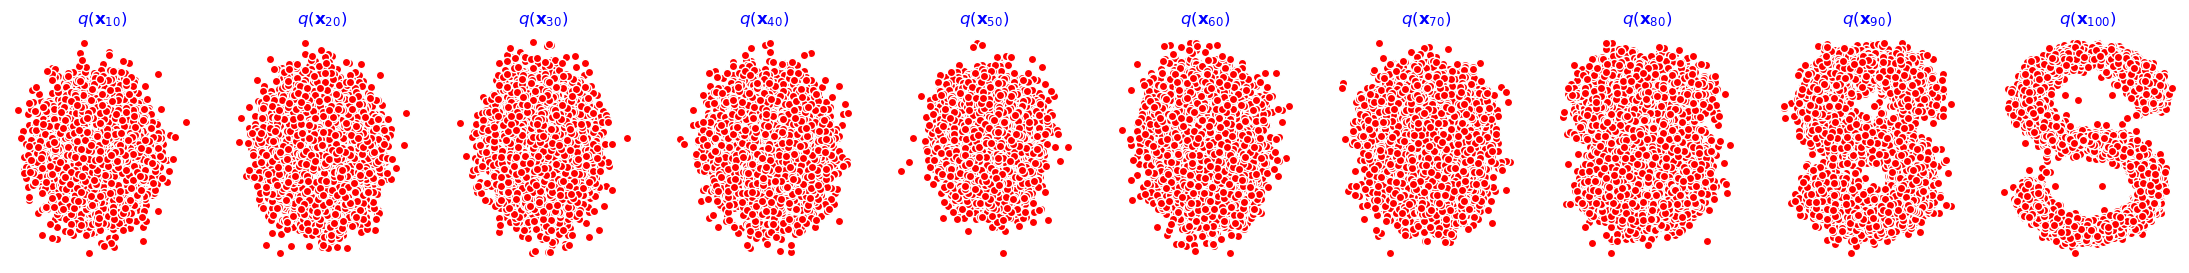

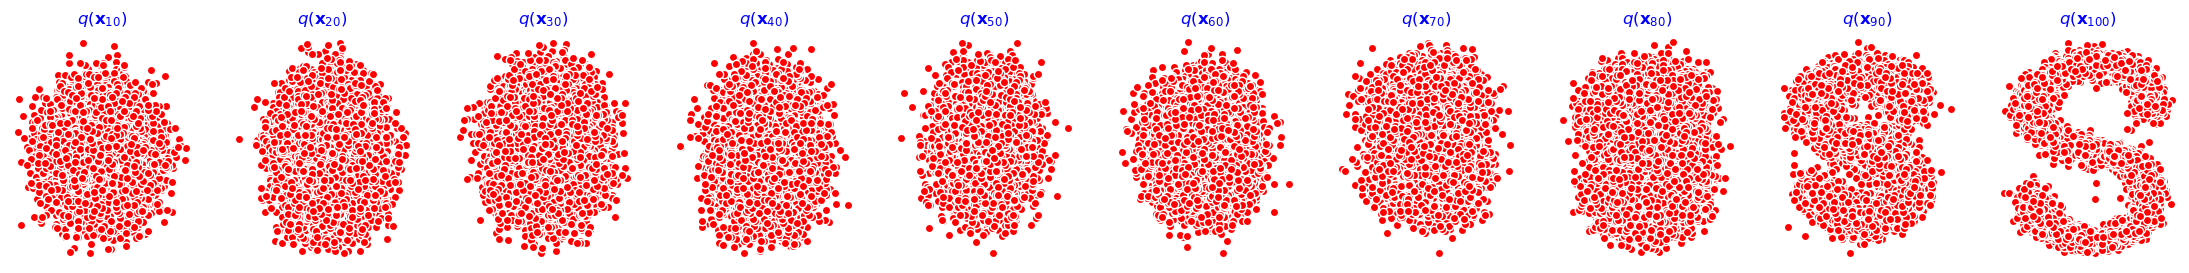

In [27]:
seed = 1234

class EMA():
    """构造一个参数平滑器"""
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}
    
    def register(self,name,val):
        self.shadow[name] = val.clone()
        
    def __call__(self,name,x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average

print('Trainning model...')

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

model = MLPDiffusion(num_steps) #输出维度的2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()
        
    if(t%100==0):
        print(loss)
        x_sep = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)
        
        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_sep[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## 动画演示扩展过程和逆扩散过程

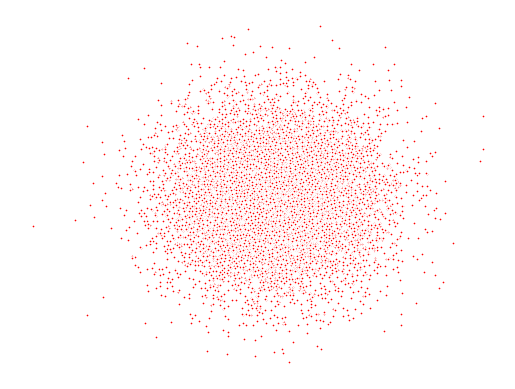

In [29]:
#生成前向过程，也是逐步加噪声

import io
from PIL import Image

imgs = []

for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    imgs.append(img)

In [32]:
reverse = []
for i in range(100):
    plt.clf()
    cur_x = x_seq[i].detach()
    plt.scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white',s=5);
    plt.axis('off')
    
    img_buf = io.BytesIO()
    plt.savefig(img_buf,format='png')
    img = Image.open(img_buf)
    reverse.append(img)

NameError: name 'x_seq' is not defined

<Figure size 640x480 with 0 Axes>

In [33]:
imgs = imgs + reverse

In [34]:
imgs[0].save('diffusion.gif',format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)